# Melbourne Street Network Analysis

Collect street network data and analyse it ready for use in modelling.

Cite OSMNX library [here](https://geoffboeing.com/publications/osmnx-complex-street-networks/)

In [1]:
import requests  # for downloading data
import os
import pickle

import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import osmnx as ox
import networkx as nx

from zipfile import ZipFile

## Load data

~First some other data so that we know the spatial extent of the area that we are using.  Use the landmarks data from the [Melbourne Open Data Portal](https://data.melbourne.vic.gov.au/People/Landmarks-and-places-of-interest-including-schools/j5vt-ppat)~

_This was unnecessary because the road network data we download are already clipped to the area of interest_

### Melbourne pedestrian network

Now get the road network data. Use the [pedestrian route data](https://data.melbourne.vic.gov.au/Transport/Pedestrian-Network/4id4-tydi) that are already available. These are shared as a `zip` file so download and extract that first if needed.

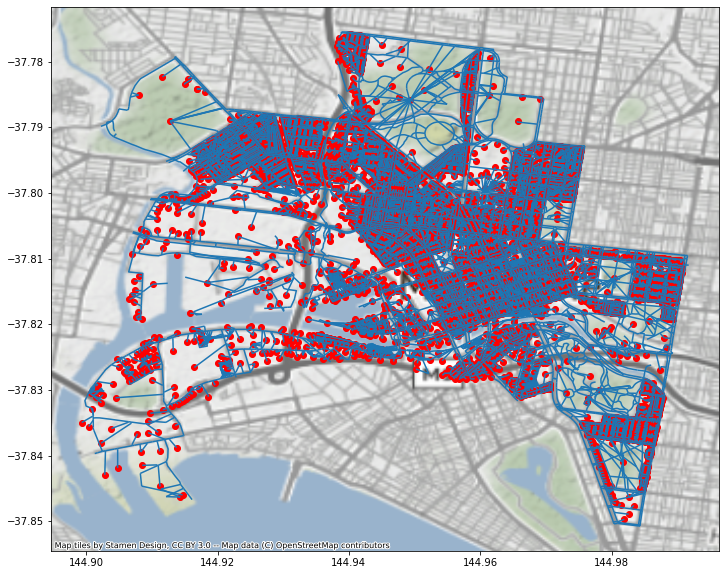

In [2]:
network_file = "Pedestrian_network.json"
property_file = "Property_centroid.json"

if not os.path.exists(network_file):
    zip_filename = "Pedestrian_Network.zip"
    print("Street network data doesn't exist, downloading ...",)
    url = "https://data.melbourne.vic.gov.au/download/4id4-tydi/application%2Fzip"
    response = requests.get(url)
    with open(zip_filename, 'wb') as f:
        f.write(response.content) 
    print("\t ... finished. Extracting zipfile ...",)
    with ZipFile(zip_filename, 'r') as zObject:
        zObject.extractall()
    # Should have two new files
    assert os.path.exists(network_file)
    assert os.path.exists(property_file)
    os.remove(zip_filename)
    
network = gpd.read_file(network_file, crs="EPSG:4326")
properties = gpd.read_file(property_file, crs="EPSG:4326")
ax = network.plot(figsize=(12,10))
properties.plot(ax=ax, color='red')
cx.add_basemap(ax, crs=network.crs, zoom=12)

### Melbourne Boundary

Get the [municipal boundary](https://data.melbourne.vic.gov.au/Property/Municipal-boundary/ck33-yh8z) (i.e. the study area). I couldn't work out how to get this one automatically so need to download manually (it's a zip file with a shapefile, and associated files, inside).

<AxesSubplot:>

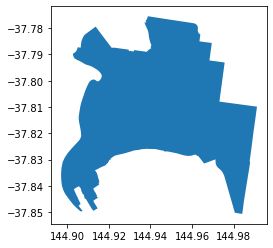

In [2]:
boundary_file = os.path.join("Municipal boundary", "geo_export_14403582-ca81-4ce2-bfcc-1421eb473132.shp")

assert os.path.exists(boundary_file), "Municipal boundary file needs downloading and extracting"

boundary = gpd.read_file(boundary_file)
boundary.plot()

## Calculate space syntax statistics

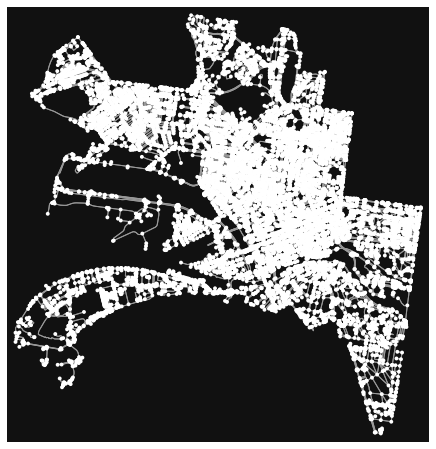

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [3]:
# Get the network using the municipal boundary
# (Need to extract the geometry, not the whole gpd https://stackoverflow.com/questions/65742407/error-when-trying-to-extract-the-information-from-polygon-osmnx )
# (Could also pickle, but creating the graph doesn't take too long https://stackoverflow.com/questions/61664525/problem-uploading-a-graph-from-a-pickle-file)
G = ox.graph_from_polygon(boundary.iloc[0]['geometry'], network_type='walk', simplify=True)

# convert graph to geodataframe
gdf_edges = ox.graph_to_gdfs(G, nodes=False)

ox.plot_graph(G)

In [4]:
basic_stats = ox.basic_stats(G)
basic_stats

{'n': 18603,
 'm': 57044,
 'k_avg': 6.13277428371768,
 'edge_length_total': 2151901.638000024,
 'edge_length_avg': 37.723540389874906,
 'streets_per_node_avg': 3.08305112078697,
 'streets_per_node_counts': {0: 0,
  1: 2623,
  2: 0,
  3: 9294,
  4: 6600,
  5: 69,
  6: 15,
  7: 2},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.14099876364027308,
  2: 0.0,
  3: 0.4995968392194807,
  4: 0.35478148685695854,
  5: 0.003709079180777294,
  6: 0.0008063215610385422,
  7: 0.00010750954147180563},
 'intersection_count': 15980,
 'street_length_total': 1075950.819000004,
 'street_segment_count': 28522,
 'street_length_avg': 37.72354038987463,
 'circuity_avg': 1.0448084896857233,
 'self_loop_proportion': 0.0010167589930579904}

### Max speed

Plot the max speed (mostly for interest, seems like most roads don't have a max speed)

In [7]:
# Tidy the max speed
# Some stored as lists and strings (stupid!) so take the average speed of all in the list
# gdf_edges.reset_index()['maxspeed'].apply(type).value_counts()  # (shows the different types)
def clean_edges(edge):
    # If posssible just return a float
    try:
        return float(edge)
    except:
        #print(f"\n {edge} \n {type(edge)} \n")
        # Could be a string separated by semi-colons
        if ';' in edge:
            l = [float(x) for x in edge.split(";")]
            return np.mean(l)
        # Could be a list 
        if type(edge) == type([]):            
            # Parse the list. Sometimes the items are just numbers, 
            # other times they are themselves mini, semi-colon lists (so stupid!)
            l = []
            for item in edge:
                if ';' in item:
                    l += [float(x) for x in item.split(";")]
                else:
                    l += [float(item)]
            return np.mean(l)        
                
    raise Exception(f"Don't know what to do with:\n\t{edge}")

gdf_edges['maxspeed'] = gdf_edges['maxspeed'].apply(clean_edges)

Text(0.5, 1.0, 'Max speeds (OSM)')

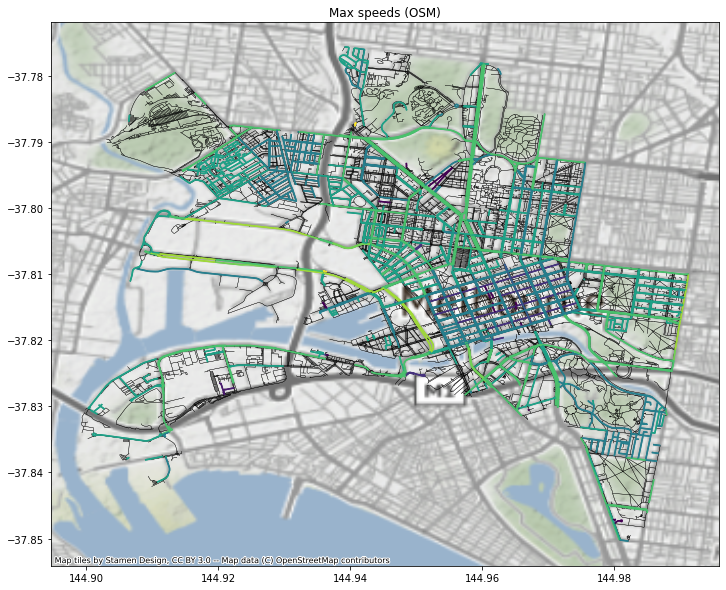

In [10]:
ax = gdf_edges.plot(color="black", linewidth=0.3, figsize=(12,10))  # Plot all roads first (including those without a max speed)
gdf_edges.plot(column="maxspeed", ax=ax)  # Then add colours for max speed
cx.add_basemap(ax, crs=gdf_edges.crs, zoom=12)
ax.set_title("Max speeds (OSM)")

### Centrality indicators

https://github.com/gboeing/osmnx-examples/blob/eaf8b989d168098d73f8f13ca1a356e4a2cf7189/notebooks/06-stats-indicators-centrality.ipynb


#### Node Betweenneess Centrality

This isn't so useful, but a good start (based on [this example](https://github.com/gboeing/osmnx-examples/blob/eaf8b989d168098d73f8f13ca1a356e4a2cf7189/notebooks/06-stats-indicators-centrality.ipynb)). I calculate edge betweenness centrality (more useful) later.

In [9]:
# calculate betweenness with a digraph of G (ie, no parallel edges)
if os.path.exists('bc.pickle'):
    print("Loading betweenness from pickle")
    bc = pickle.load(open('bc.pickle', 'rb'))
else:
    print("(Re) calculating betweenneess centrality, this may take an hour or two")
    bc = nx.betweenness_centrality(ox.get_digraph(G), weight="length")
    pickle.dump(bc, open('bc.pickle', 'wb'))

Loading betweenness from pickle
Node 86674159 has the highest betweenness, with 15.4% of all shortest paths running through it


Which node has the highest betweenness?

In [12]:
max_node, max_bc = max(bc.items(), key=lambda x: x[1])
print(f"Node {max_node} has the highest betweenness, with {round(max_bc*100,2)}% of all shortest paths running through it") 

Node 86674159 has the highest betweenness, with 15.4% of all shortest paths running through it


Plot the node with the highest betweenness:

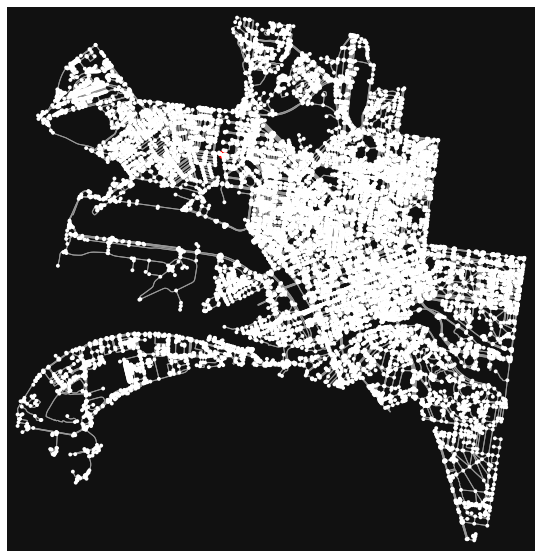

In [7]:
nc = ["r" if node == max_node else "w" for node in G.nodes]
ns = [80 if node == max_node else 15 for node in G.nodes]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2, figsize=(12,10))

Plot betweenness centrality of all nodes

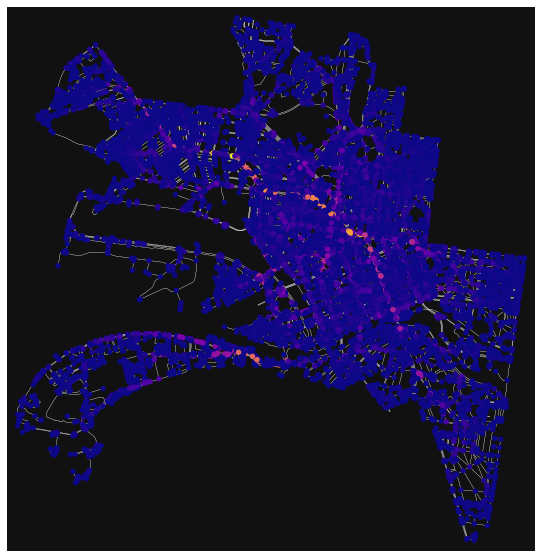

In [35]:
# add the betweenness centraliy values as new node attributes, then plot
nx.set_node_attributes(G, bc, "bc")
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="plasma")
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=30,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
    figsize=(12,10),
)

#### Edge Betweenneess Centrality

One of the centrality measures available in NetworkX (see [Network X centrality docs](https://networkx.org/documentation/stable/reference/algorithms/centrality.html)).

In [19]:
# calculate betweenness with a digraph of G (ie, no parallel edges)
if os.path.exists('ebc.pickle'):
    print("Loading betweenness from pickle")
    ebc = pickle.load(open('ebc.pickle', 'rb'))
else:
    print("(Re) calculating edge betweenneess centrality, this may take an hour or two")
    ebc = nx.edge_betweenness_centrality(ox.get_digraph(G), weight="length")
    pickle.dump(bc, open('ebc.pickle', 'wb'))

(Re) calculating edge betweenneess centrality, this may take an hour or two


Link the edge betweenness back to the original edges geodataframe

In [50]:
gdf_edges['betweenness'] = gdf_edges.index.map(ebc)

The distribution has a very long tail:

<AxesSubplot:>

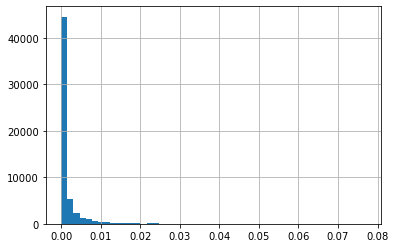

In [67]:
gdf_edges['betweenness'].hist(bins=50)

Neeed to normalise. Log doesn't help much as there are some edges with betweeness=0, and adding 1 to all values before logging still results in quite a skewed distribution. Use square root instead

<AxesSubplot:>

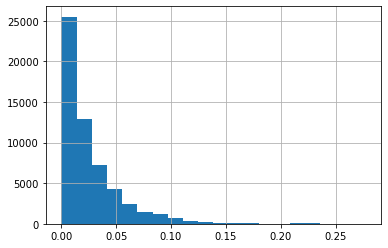

In [69]:
np.sqrt(gdf_edges['betweenness']).hist(bins=20)

<AxesSubplot:>

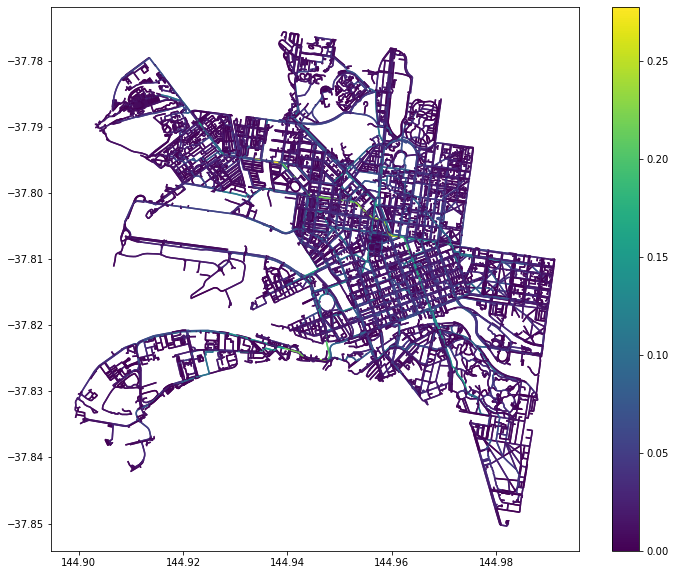

In [66]:
gdf_edges['betweenness_sqrt'] = np.sqrt(gdf_edges['betweenness'])
gdf_edges.plot(column='betweenness_sqrt', figsize=(12,10), legend=True)

Write this out (useful for a GIS with a GUI)

In [84]:
gdf_edges.reset_index().loc[:,['u','v','betweenness','betweenness_log', 'geometry']].to_file("gdf_edges.shp")

/var/folders/rc/y11tftws5_7bfyh76v48dbbm0000gn/T/ipykernel_11129/2175023618.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_edges.reset_index().loc[:,['u','v','betweenness','betweenness_log', 'geometry']].to_file("gdf_edges.shp")
